In [1]:
import numpy as np
import astropy.units as u
import scipy 
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [46]:
G = (2*np.pi)**2
rhill = 0.3543

Mstar = 1
Mp = 9.543e-4
xp = 5.2 
a = .2*rhill
e = 0.002

In [47]:
def acc(x, y, z, xdot, ydot, zdot, M, xp):
#    Input:  x,y,z -- current planetocentric cartesian coordinates of moon
#            xdot, ydot, zdot -- current velocities in each direction
#            Omega -- current angular frequency, based on latest M_star and x_p
#            
#    Output: Three values, qualifying acceleration in x, y, and z directions
#            These can be easily changed to decide whether or not to consider Omega 
    
    Omega = np.sqrt((G*M)/xp**3)
    delta = np.sqrt(x**2 + y**2)
    
    x_no_om = -(G*Mp*x) / delta**3 # x accel term with omega = 0, even though that doesn't make sense, just to check
    y_no_om = -(G*Mp*y) / delta**3 # y accel same as above
    
    x_acc = 2*Omega*ydot + (3*Omega**2 - (G*Mp) / delta**3)*x # complete x accel
    y_acc = -2*Omega*xdot - (G*Mp*y) / delta**3               # complete y accel
    z_acc = 0                                         # if we were using z, it'd go here
    
    return x_acc, y_acc, z_acc

def compute_energy(x,y,z,u,v,w):
    ke = 0. ; pe = 0.
    for i in range(nbody):
        ke += 0.5*m[i]*(u[i]**2+v[i]**2+w[i]**2)        # compute kinetic energy of mass i
        jlist = [k for k in range(nbody) if k > i]      # do sum over masses k > i
    for j in jlist:
        xsep = x[j]-x[i]                              # compute potential energy of mass i
        ysep = y[j]-y[i]
        zsep = z[j]-z[i]
        pe  -= m[i]*m[j]*(xsep**2+ysep**2+zsep**2)**(-0.5)
    return (ke+pe)/gconst                             # return total energy (in proper units)

In [48]:
T = np.sqrt(a**3 / Mp) # calculates period of the moon around planet
print("Period:",T,"yrs")

Period: 0.6106034588357296 yrs


In [49]:
def Msol_loss(M0, t):
    return M0 * np.e**(-t/10000) 

def xp_chng(xp0, M0, M):
    return xp0 * (M0/M)

In [50]:
dt = T/10000                # sets a timestep of 1/1000th the moon's initial period
dt2 = dt/2                  # half timestep
years = T*600               # how many years we want to integrate for
steps = int(int(years)/dt)  # how many steps it'll take to integrate that length of time
t = np.zeros(steps)

for i in range(steps - 1):
    t[i+1] = t[i] + dt

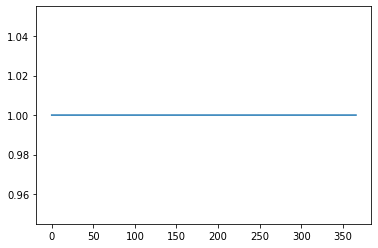

In [51]:
star_data = np.loadtxt("Sun_track.txt")
# Mstar_vals = star_data[:,1]
# times = star_data[:,0]

Mstar_vals = np.zeros(steps); xp_vals = np.zeros(steps); Om_vals = np.zeros(steps)

Mstar_vals[0] = Mstar
xp_vals[0] = xp                      # sets initial M_star and x_p
Om_vals[0] = np.sqrt(G*Mstar / xp**3)   # calculates/sets initial Omega

for i in range(steps - 1):
    Mstar_vals[i + 1] = Msol_loss(Mstar, 0)
    xp_vals[i + 1] = xp_chng(xp, Mstar, Mstar_vals[i+1])
    
    Om_vals[i + 1] = np.sqrt(G * Mstar_vals[i + 1] / xp_vals[i + 1]**3)
    
plt.plot(t, Mstar_vals)
plt.show()

In [52]:
#n = len(radii)

###############
# First, we initialize a bunch of empty arrays for our integration. They all have one entry 
# for every step. We need arrays for time, positions/velos of moons, stellar mass,
# distance from planet to star, and angular frequency. We also set up arrays for half-dt 
# positions for the moons.
###############

x = np.zeros(steps) ; y = np.zeros(steps) ; z = np.zeros(steps)
u = np.zeros(steps) ; v = np.zeros(steps) ; w = np.zeros(steps)

xh = np.zeros(steps) ; yh = np.zeros(steps) ; zh = np.zeros(steps)

enrg = np.zeros(steps)

###############
# Fill in initial values for these arrays based on values defined in previous cells.
###############

r0 = a*(1-e*e)/(1+e)                 # calculates initial x-displacement of moon
v0 = np.sqrt(G*Mp*(2/r0-1/a))        # calculates initial velo of moon

x[0] = r0  ; y[0] = 0   ; z[0] = 0   # sets initial positions/velos of moon
u[0] = 0   ; v[0] = v0  ; w[0] = 0

###############
# With everything set up, we can now perform a quick Runge-Kutta 2 integration
# to update positions of moon (in planetocentric) and planet for the first half timestep.
###############

# declare temporary storage arrays for RK integration
k1 = np.zeros((2,6)) ; k2 = np.zeros((2,6))
ix = 0 ; iy = 1 ; iz = 2 ; iu = 3 ; iv = 4 ; iw = 5

# RK2 integration for very first half timestep for moon
  # stage 1
# compute gravitational acceleration of moon based on planetocentric positions and velos
ax,ay,az = acc(x[0],y[0],z[0],u[0],v[0],w[0], Mstar_vals[0], xp_vals[0])
  # store k1
k1[0,ix] = dt2*u[0]
k1[0,iy] = dt2*v[0]
k1[0,iz] = dt2*w[0]
k1[0,iu] = dt2*ax
k1[0,iv] = dt2*ay
k1[0,iw] = dt2*az
  
  # stage 2
# compute gravitational acceleration of moon based on planetocentric positions and velos
ax,ay,az = acc(x[0]+0.5*k1[0,ix], y[0]+0.5*k1[0,iy], z[0]+0.5*k1[0,iz], 
               u[0]+0.5*k1[0,iu], v[0]+0.5*k1[0,iv], w[0]+0.5*k1[0,iw],
               Mstar_vals[0], xp_vals[0])
  # store k2
k2[0,ix] = dt2*(u[0]+0.5*k1[0,iu])
k2[0,iy] = dt2*(v[0]+0.5*k1[0,iv])
k2[0,iz] = dt2*(w[0]+0.5*k1[0,iw])
k2[0,iu] = dt2*ax
k2[0,iv] = dt2*ay
k2[0,iw] = dt2*az
  
  # update position of moon
xh[0] = x[0] + k2[0,ix]
yh[0] = y[0] + k2[0,iy]
zh[0] = z[0] + k2[0,iz]

#enrg[0] = compute_energy(x[0],y[0],z[0],u[0],v[0],w[0])

###############
# We now have the moon at its position at t = dt/2
# We can now proceed with leapfrog integration for the rest of the desired period
###############

inc = 0

# This while loop draws heavily from 
# https://sites.google.com/a/ucsc.edu/krumholz/teaching-and-courses/ast119_w15/class-11#TOC-Solving-for-Orbital-Motion-on-a-Computer:-The-Leapfrog-Method
while (inc < steps - 1):    
    
    # perform leapfrog for moon -- 
    #     update acc based on previous position, update velos, then update positions
    ax, ay, az = acc(xh[inc], yh[inc], zh[inc], u[inc], v[inc], w[inc], Mstar_vals[inc], xp_vals[inc])
       
    u[inc + 1] = u[inc] + dt*ax
    v[inc + 1] = v[inc] + dt*ay
    w[inc + 1] = w[inc] + dt*az
    
    x[inc + 1] = xh[inc] + dt2*u[inc + 1]
    y[inc + 1] = yh[inc] + dt2*v[inc + 1]
    z[inc + 1] = zh[inc] + dt2*w[inc + 1]
    
    xh[inc + 1] = xh[inc] + dt*u[inc + 1]
    yh[inc + 1] = yh[inc] + dt*v[inc + 1]
    zh[inc + 1] = zh[inc] + dt*w[inc + 1]
    
    #enrg[inc+1] = compute_energy(x[inc+1],y[inc+1],z[inc+1],u[inc+1],v[inc+1],w[inc+1])
    
    # If the moon gets too close, we stop integration to keep it from crashing
    # into the planet/shooting far out, recording the step on which we stop
    
    if (np.sqrt(xh[inc+1]**2 + yh[inc+1]**2 + zh[inc+1]**2) < 0.005):
        print("The moon crashed!")
        break
        
    inc += 1

end = inc
print(end)

The moon crashed!
201021


In [53]:
print(u[:end],v[:end])

[ 0.         -0.00409064 -0.00818107 ...  2.29529192  2.6584012
  2.7545436 ] [ 0.73061796  0.73060346  0.73056258 ... -1.41061607 -0.62995037
  0.24865474]


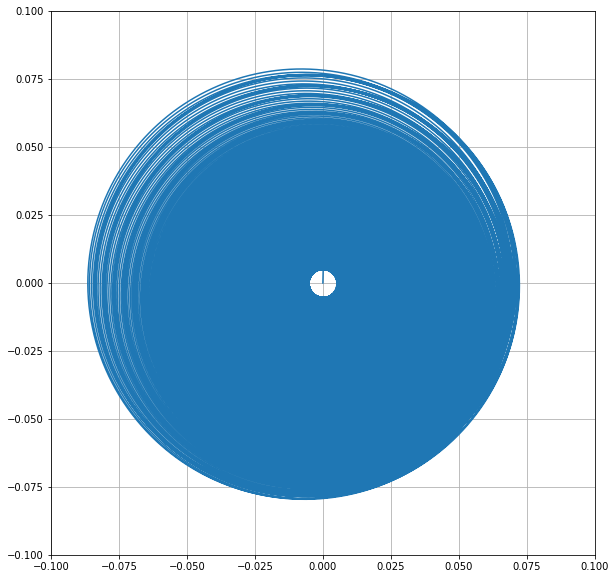

In [54]:
orbit, orbplt = plt.subplots(figsize=(10,10))

xprime = np.zeros_like(xh); yprime = np.zeros_like(yh)
xprime[0] = xh[0];          yprime[0] = yh[0]
for i in range(steps - 1):
    xprime[i+1] = xprime[i] + (xh[i+1] - xh[i]) - xp_vals[i+1]*np.cos(Om_vals[i+1]*dt)
    yprime[i+1] = yprime[i] + (yh[i+1] - yh[i]) - xp_vals[i+1]*np.sin(Om_vals[i+1]*dt)

xprime = xh*np.cos(Om_vals*t) - yh*np.sin(Om_vals*t)
yprime = xh*np.sin(Om_vals*t) + yh*np.cos(Om_vals*t)
orbplt.plot(xprime, yprime)
#orbplt.plot(xh[int(1.1e5):int(1.2e5)],yh[int(1.1e5):int(1.2e5)])
#orbplt.plot(xh[int(1.2e5):int(1.3e5)],yh[int(1.2e5):int(1.3e5)])
#orbplt.plot(xh[int(1.3e5):int(1.4e5)],yh[int(1.3e5):int(1.4e5)])
#orbplt.plot(xh[int(1.443e5):int(1.444e5)],yh[int(1.443e5):int(1.444e5)])
orbplt.set_xlim(-.30,.30)
orbplt.set_ylim(-.30,.30)
#orbplt.set_xticks([-.4,0,.4])
#orbplt.set_yticks([-.4,0,.4])
#orbplt.set_xticklabels([-0.40,0,0.40])
#orbplt.set_yticklabels([-0.40,0,0.40])
orbplt.grid(b=True,which='major', axis='both')
orbplt.set_aspect('equal')

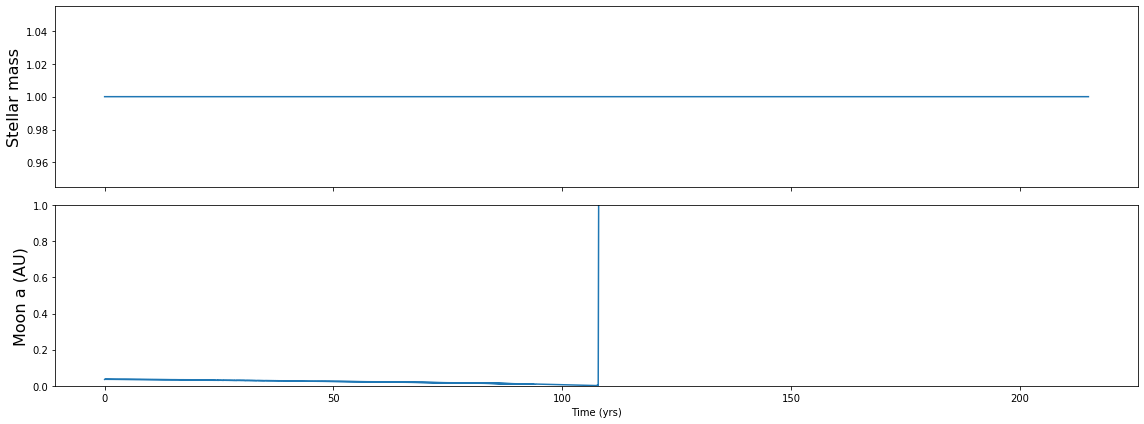

In [35]:
radiuses = np.sqrt(xprime[:end]**2 + yprime[:end]**2)
thetas = np.arctan(yprime[:end]/xprime[:end])

semimajor = np.empty_like(radiuses)
semimajor = (radiuses * (1 + e*np.cos(thetas)))/(1 - e**2)

changes, ax = plt.subplots(2, figsize=(16,6), sharex=True)

ax[0].plot(t[:end],Mstar_vals[:end])
ax[0].set_ylabel("Stellar mass", fontsize=16)
ax[1].plot(t[:end],semimajor[:end])
ax[1].set_ylabel("Moon a (AU)", fontsize=16)
ax[1].set_xlabel("Time (yrs)")
ax[1].set_ylim(0,1)

changes.tight_layout()

## Same thing, with acceleration from Yarkovsky

In [43]:
G = (2*np.pi)**2
rhill = 0.3543

Mstar = 1
Mp = 9.543e-4
xp = 5.2 
ep = 0.0489
a = .3*rhill
e = 0.02

In [44]:
Lstar = 3.828e26 #luminosity of the Sun (J/s)
L0 = Lstar
c = 2.998e8       #speed of light (m/s)
D = 10000         #diameter of moon (m)
roh = 4000        #density of moon (kg/m^3)
zeta = 1        #efficiency factor???

In [45]:
def acc_wyar(x, y, z, xdot, ydot, zdot, Omega, A):
    delta = np.sqrt(x**2 + y**2)
    
    ax =  2*Omega*ydot + x*((3*Omega**2)       - (G*Mp) / delta**3) + A*r**(-3/2)*y*(1 - (3*x)/r)
    ay = -2*Omega*xdot - y*((G*Mp) / delta**3) + A*(1/np.sqrt(r)    - 3*(x**2)*(r**(-5/2))        - 2*x*(r**(-3/2)))
    az = 0
    
    return ax, ay, az

def A_L(L):
    # A_ms returns a value with units
    # m^2*kg^-1*kg*m^2*s^-2  =  m^4*s^-2
    
    A_ms = zeta * 3/(8*np.pi) * 1/(D*roh) * L/c
    
    m4_to_au4 = 1.9966335e-45
    s2_to_yr2 = 1.0041778e-15
    
    A_ay = A_ms * (m4_to_au4 / s2_to_yr2)
    
    return A_ay

def L_sun(M):
    return L0 * (M/M0)**(3.5)

In [46]:
def Msol_loss(M0, t):
    power = (-t)/(100000)
    return M0 * np.e**(power)

In [47]:
T = np.sqrt(a**3 / Mp)
print("Period:",T,"yrs")

dt = T/1000
dt2 = dt/2
years = 600
steps = int(int(years)/dt)

nmoons = 5

t = np.zeros(steps)
x = np.zeros(steps) ; y = np.zeros(steps) ; z = np.zeros(steps)
u = np.zeros(steps) ; v = np.zeros(steps) ; w = np.zeros(steps)
xJ = np.zeros(steps); yJ = np.zeros(steps); zJ = np.zeros(steps)
uJ = np.zeros(steps); vJ = np.zeros(steps); wJ = np.zeros(steps)
Mstar_vals = np.zeros(steps); xp_vals = np.zeros(steps); Om_vals = np.zeros(steps)
A_vals = np.zeros(steps); L_vals = np.zeros(steps)

xh = np.zeros(steps) ; yh = np.zeros(steps) ; zh = np.zeros(steps)
xhJ = np.zeros(steps); yhJ = np.zeros(steps); zhJ = np.zeros(steps)

r0 = a*(1-e*e)/(1+e)
v0 = np.sqrt(G*Mp*(2/r0-1/a))

r0J = xp*(1-ep*ep)/(1+ep)
v0J = np.sqrt(G*M0*(2/r0J-1/xp))

x[0] = r0  ; y[0] = 0   ; z[0] = 0
u[0] = 0   ; v[0] = v0  ; w[0] = 0
xJ[0] = r0J; yJ[0] = 0  ; zJ[0] = 0
uJ[0] = 0  ; vJ[0] = v0J; wJ[0] = 0
Mstar_vals[0] = M0; xp_vals[0] = xp
Om_vals[0] = G*M0 / xp**3
L_vals[0] = L_sun(Mstar_vals[0])
A_vals[0] = A_L(L_vals[0])

# declare temporary storage arrays for RK integration
k1 = np.zeros((2,6)) ; k2 = np.zeros((2,6))
ix = 0 ; iy = 1 ; iz = 2 ; iu = 3 ; iv = 4 ; iw = 5

# RK2 integration for very first half timestep
  # stage 1
# compute gravitational acceleration of mass i due to all masses j != i
ax,ay,az = acc_wyar(x[0],y[0],z[0],u[0],v[0],w[0], Om_vals[0], A_vals[0])
# store k1
k1[0,ix] = dt2*u[0]
k1[0,iy] = dt2*v[0]
k1[0,iz] = dt2*w[0]
k1[0,iu] = dt2*ax
k1[0,iv] = dt2*ay
k1[0,iw] = dt2*az
  
  # stage 2
    # compute gravitational acceleration of mass i due to all masses j != i
ax,ay,az = acc_wyar(x[0]+0.5*k1[0,ix], y[0]+0.5*k1[0,iy], z[0]+0.5*k1[0,iz], 
                    u[0]+0.5*k1[0,iu], v[0]+0.5*k1[0,iv], w[0]+0.5*k1[0,iw],
                    Om_vals[0], A_vals[0])
    # store k2
k2[0,ix] = dt2*(u[0]+0.5*k1[0,iu])
k2[0,iy] = dt2*(v[0]+0.5*k1[0,iv])
k2[0,iz] = dt2*(w[0]+0.5*k1[0,iw])
k2[0,iu] = dt2*ax
k2[0,iv] = dt2*ay
k2[0,iw] = dt2*az
  
  # update position of moon
xh[0] = x[0] + k2[0,ix]
yh[0] = y[0] + k2[0,iy]
zh[0] = z[0] + k2[0,iz]


# RK2 integration for very first half timestep
  # stage 1
# compute gravitational acceleration of mass i due to all masses j != i
ax,ay,az = acc_simple(xJ[0],yJ[0],zJ[0],M0)
# store k1
k1[1,ix] = dt2*uJ[0]
k1[1,iy] = dt2*vJ[0]
k1[1,iz] = dt2*wJ[0]
k1[1,iu] = dt2*ax
k1[1,iv] = dt2*ay
k1[1,iw] = dt2*az
  
  # stage 2
    # compute gravitational acceleration of mass i due to all masses j != i
ax,ay,az = acc_simple(xJ[0]+0.5*k1[1,ix], yJ[0]+0.5*k1[1,iy], zJ[0]+0.5*k1[1,iz], M0)
    # store k2
k2[1,ix] = dt2*(uJ[0]+0.5*k1[1,iu])
k2[1,iy] = dt2*(vJ[0]+0.5*k1[1,iv])
k2[1,iz] = dt2*(wJ[0]+0.5*k1[1,iw])
k2[1,iu] = dt2*ax
k2[1,iv] = dt2*ay
k2[1,iw] = dt2*az
  
  # update position of moon
xhJ[0] = xJ[0] + k2[1,ix]
yhJ[0] = yJ[0] + k2[1,iy]
zhJ[0] = zJ[0] + k2[1,iz]

inc = 0

# This while loop draws heavily from 
# https://sites.google.com/a/ucsc.edu/krumholz/teaching-and-courses/ast119_w15/class-11#TOC-Solving-for-Orbital-Motion-on-a-Computer:-The-Leapfrog-Method
while (inc < steps - 1):    
    t[inc + 1] = t[inc] + dt
    
    Mstar_vals[inc + 1] = Msol_loss(M0, t[inc + 1])
    
    axJ, ayJ, azJ = acc_simple(xhJ[inc], yhJ[inc], zhJ[inc], Mstar_vals[inc])

    uJ[inc + 1] = uJ[inc] + dt*axJ
    vJ[inc + 1] = vJ[inc] + dt*ayJ
    wJ[inc + 1] = wJ[inc] + dt*azJ
    
    xJ[inc + 1] = xhJ[inc] + dt2*uJ[inc + 1]
    yJ[inc + 1] = yhJ[inc] + dt2*vJ[inc + 1]
    zJ[inc + 1] = zhJ[inc] + dt2*wJ[inc + 1]
    
    xhJ[inc + 1] = xhJ[inc] + dt*uJ[inc + 1]
    yhJ[inc + 1] = yhJ[inc] + dt*vJ[inc + 1]
    zhJ[inc + 1] = zhJ[inc] + dt*wJ[inc + 1]
    
    xp_vals[inc + 1] = np.sqrt(xhJ[inc + 1]**2 + yhJ[inc + 1]**2)
    Om_vals[inc + 1] = G*Mstar_vals[inc + 1] / (xp_vals[inc + 1])**3
    L_vals[inc + 1] = L_sun(Mstar_vals[inc + 1])
    A_vals[inc + 1] = A_L(L_vals[inc + 1])
    
    ax, ay, az = acc_wyar(xh[inc], yh[inc], zh[inc], u[inc], v[inc], w[inc], Om_vals[inc], A_vals[inc])

    u[inc + 1] = u[inc] + dt*ax
    v[inc + 1] = v[inc] + dt*ay
    w[inc + 1] = w[inc] + dt*az
    
    x[inc + 1] = xh[inc] + dt2*u[inc + 1]
    y[inc + 1] = yh[inc] + dt2*v[inc + 1]
    z[inc + 1] = zh[inc] + dt2*w[inc + 1]
    
    xh[inc + 1] = xh[inc] + dt*u[inc + 1]
    yh[inc + 1] = yh[inc] + dt*v[inc + 1]
    zh[inc + 1] = zh[inc] + dt*w[inc + 1]
    
    if (np.sqrt(xh[inc+1]**2 + yh[inc+1]**2 + zh[inc+1]**2) < 0.005):
        end = inc
        print(end)
        break
        
    
    inc += 1

Period: 1.1217501819945375 yrs
205378


In [48]:
print(u, v)

[ 0.         -0.00348471 -0.00689743 ...  0.          0.
  0.        ] [0.60738376 0.60737102 0.60733536 ... 0.         0.         0.        ]


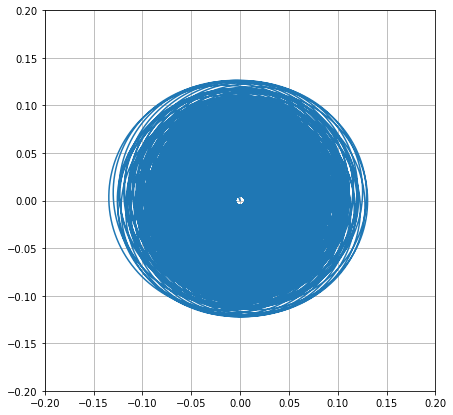

In [49]:
orbit, orbplt = plt.subplots(figsize=(7,7))

x = xh
y = yh

orbplt.plot(x,y)
orbplt.set_xlim(-.2,.2)
orbplt.set_ylim(-.2,.2)
#orbplt.set_xticks([-.4,0,.4])
#orbplt.set_yticks([-.4,0,.4])
#orbplt.set_xticklabels([-0.40,0,0.40])
#orbplt.set_yticklabels([-0.40,0,0.40])
orbplt.grid(b=True,which='major', axis='both')

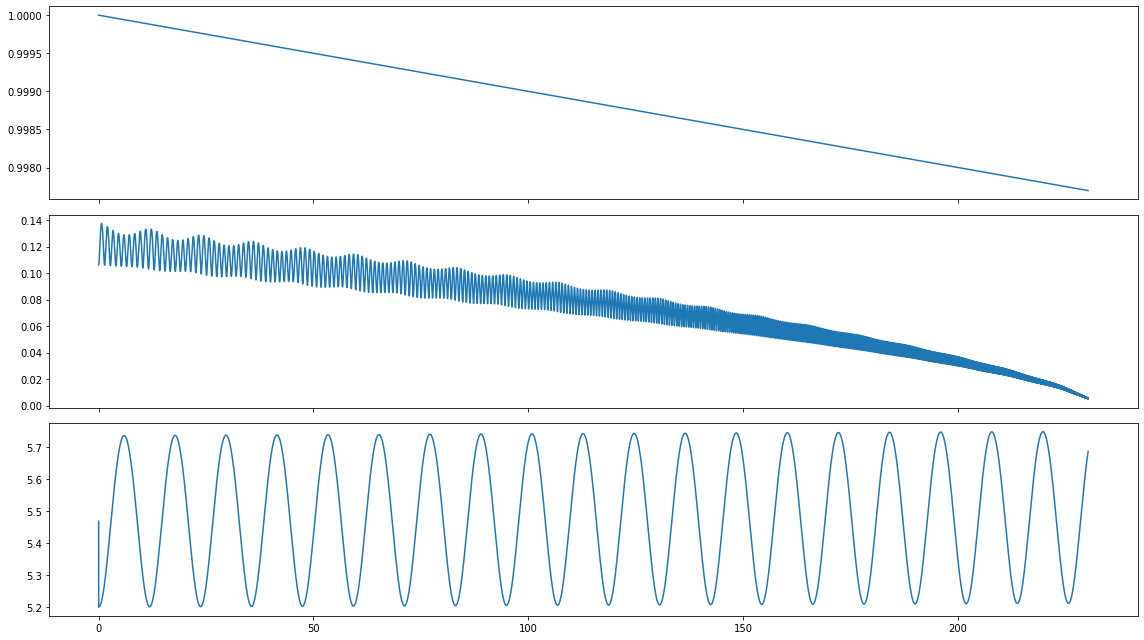

In [50]:
radiuses = np.sqrt(x**2 + y**2)

radiuses = np.sqrt(xh[:end]**2 + yh[:end]**2)
thetas = np.arctan(yh[:end]/xh[:end])
Jthets = np.arctan(yhJ[:end]/xhJ[:end])

semimajor = (radiuses * (1 + e))/(1 - e**2)
aJup = (xp_vals * (1 + ep))/(1 - ep*ep)

changes, ax = plt.subplots(3, figsize=(16,9), sharex=True)

ax[0].plot(t[:end],Mstar_vals[:end])
ax[1].plot(t[:end],semimajor[:end])
#ax[1].set_ylim(0,1)
ax[2].plot(t[:end],aJup[:end])

changes.tight_layout()